In [2]:
import gensim.downloader as api
import pandas as pd
import numpy as np
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA
# from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score, average_precision_score


2025-04-30 11:51:35.537544: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-30 11:51:35.541155: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-30 11:51:35.596175: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-30 11:51:35.597073: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-30 11:51:36.545189: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
csv = "../../data/contaminated/contaminated_data_bis.csv"
contaminated = pd.read_csv(csv).iloc[:, 0]
indices = np.load("../../data/contaminated/indices_anomalies_bis.npy").flatten().tolist()

In [4]:
contaminated.size

2862

In [5]:
def vetorisation_sbert(data, indice_anomalie=None):
    model = SentenceTransformer('sentence-transformers/all-distilroberta-v1')
    vecteurs = model.encode(data)
    vecteurs = np.array(vecteurs)

    tsne = TSNE(n_components=2, random_state=42)  
    vecteurs_2d = tsne.fit_transform(vecteurs)  
    
    # couleurs des points ( rouge : anomalie, bleu : noraml)
    couleurs = ['b'] * len(data)
    if indice_anomalie:
        for i in indice_anomalie:
            if 0 <= i < len(data): 
                couleurs[i] = 'r'

    plt.figure(figsize=(60, 30)) 
    plt.scatter(vecteurs_2d[:, 0], vecteurs_2d[:, 1], c=couleurs, marker='o') 

    plt.title("ReprÃ©sentation graphique des documents vectorisÃ©s")
    plt.grid(True)
    #plt.savefig("output.jpg")
    plt.show()
    return vecteurs

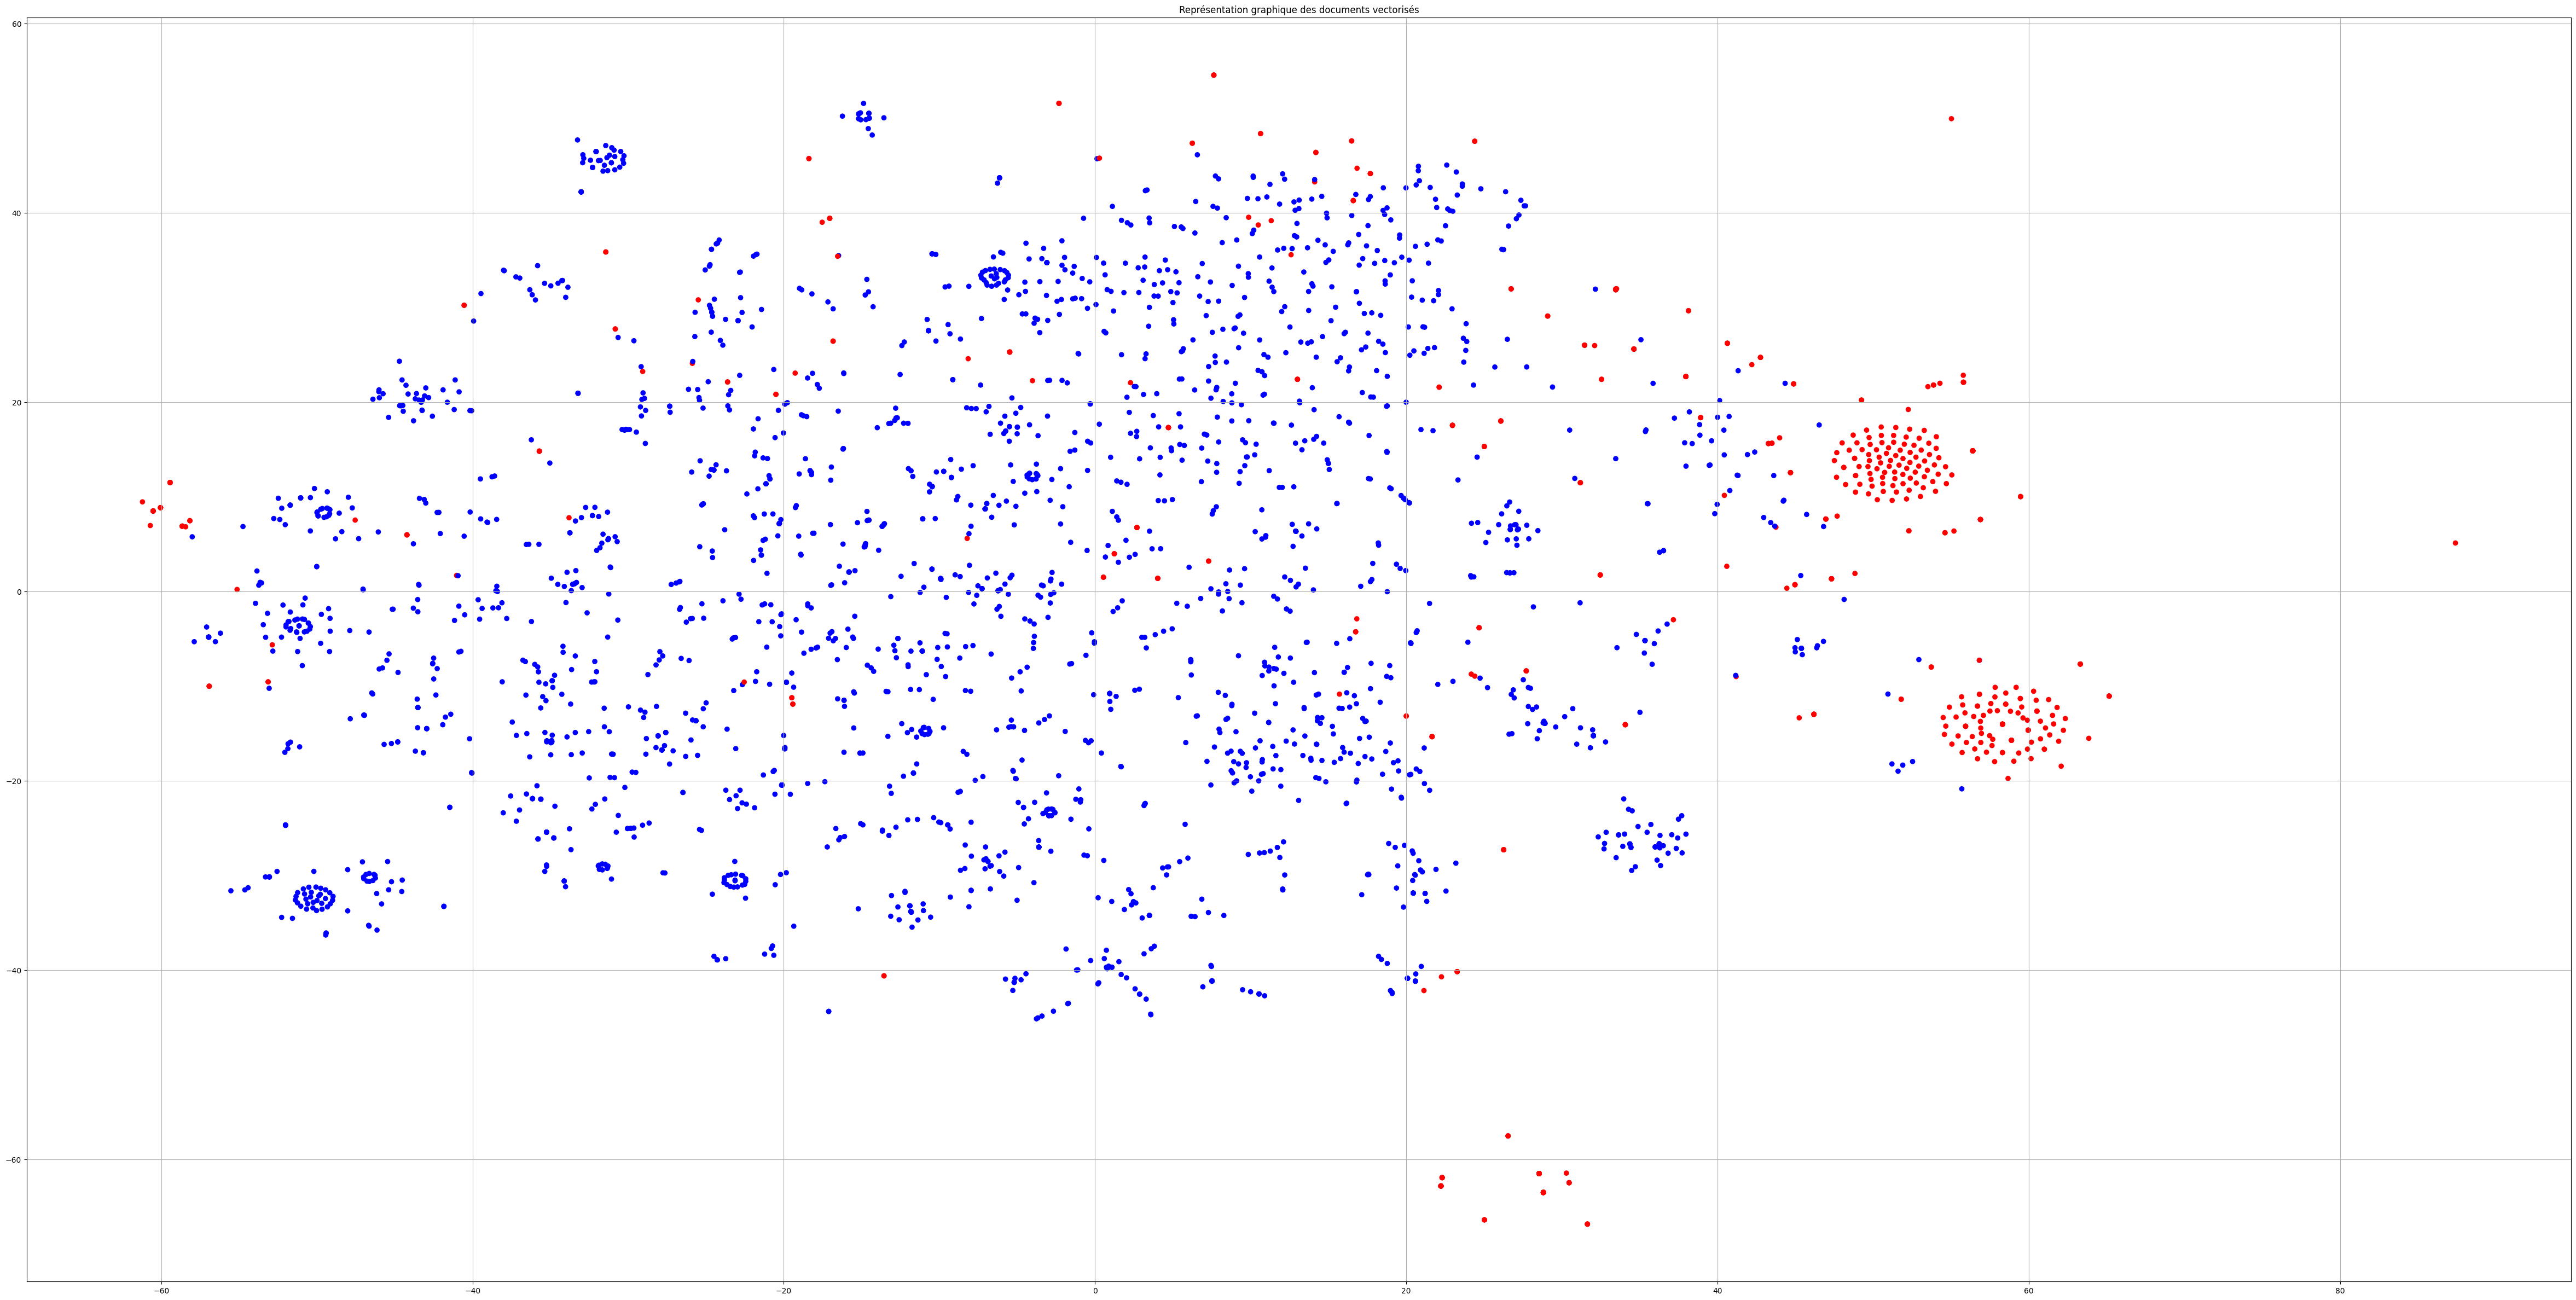

In [6]:
anomalie_sb = vetorisation_sbert(contaminated, indices)

In [49]:
tsne = TSNE(n_components=2, random_state=42)  
anomalie_sb = tsne.fit_transform(anomalie_sb)

anomaly_indices = indices  
normal_indices = list(set(contaminated.index) - set(anomaly_indices))

anomaly_train_idx, anomaly_test_idx = train_test_split(anomaly_indices, test_size=0.2, random_state=42)

normal_train_idx, normal_test_idx = train_test_split(normal_indices, test_size=0.2, random_state=42)

train_indices = anomaly_train_idx + normal_train_idx
test_indices = anomaly_test_idx + normal_test_idx

df_train = anomalie_sb[train_indices]
df_test = anomalie_sb[test_indices]

In [31]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),     # Normalisation batch sur vecteurs
            nn.ReLU(),
            nn.Linear(256, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

In [32]:
anomalie_tensor = torch.tensor(df_train, dtype=torch.float32)
dataset = TensorDataset(anomalie_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = Autoencoder(input_dim=df_train.shape[1], latent_dim = 64)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0] 
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/50, Loss: 0.0032
Epoch 2/50, Loss: 0.0007
Epoch 3/50, Loss: 0.0007
Epoch 4/50, Loss: 0.0007
Epoch 5/50, Loss: 0.0009
Epoch 6/50, Loss: 0.0006
Epoch 7/50, Loss: 0.0006
Epoch 8/50, Loss: 0.0011
Epoch 9/50, Loss: 0.0005
Epoch 10/50, Loss: 0.0005
Epoch 11/50, Loss: 0.0004
Epoch 12/50, Loss: 0.0005
Epoch 13/50, Loss: 0.0005
Epoch 14/50, Loss: 0.0005
Epoch 15/50, Loss: 0.0005
Epoch 16/50, Loss: 0.0008
Epoch 17/50, Loss: 0.0004
Epoch 18/50, Loss: 0.0003
Epoch 19/50, Loss: 0.0004
Epoch 20/50, Loss: 0.0004
Epoch 21/50, Loss: 0.0005
Epoch 22/50, Loss: 0.0005
Epoch 23/50, Loss: 0.0005
Epoch 24/50, Loss: 0.0004
Epoch 25/50, Loss: 0.0005
Epoch 26/50, Loss: 0.0003
Epoch 27/50, Loss: 0.0007
Epoch 28/50, Loss: 0.0005
Epoch 29/50, Loss: 0.0004
Epoch 30/50, Loss: 0.0004
Epoch 31/50, Loss: 0.0003
Epoch 32/50, Loss: 0.0005
Epoch 33/50, Loss: 0.0003
Epoch 34/50, Loss: 0.0004
Epoch 35/50, Loss: 0.0007
Epoch 36/50, Loss: 0.0004
Epoch 37/50, Loss: 0.0004
Epoch 38/50, Loss: 0.0003
Epoch 39/50, Loss: 0.


ðŸ”¥ Meilleur seuil trouvÃ© : 0.000495
ðŸ“ˆ F1-score optimal : 0.5622

ðŸ“Š Rapport de classification :

              precision    recall  f1-score   support

      Normal       0.89      0.91      0.90       458
    Anomalie       0.60      0.53      0.56       115

    accuracy                           0.83       573
   macro avg       0.74      0.72      0.73       573
weighted avg       0.83      0.83      0.83       573

AUC ROC : 0.7205
Average precision : 0.4115


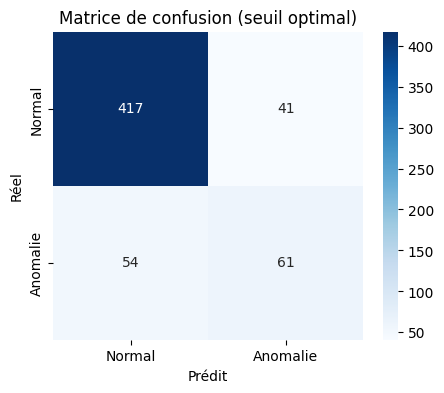

In [33]:
model.eval()
with torch.no_grad():
    inputs = torch.tensor(df_test, dtype=torch.float32)
    reconstructions = model(inputs)
    mse = torch.mean((inputs - reconstructions) ** 2, dim=1)

mse = mse.numpy()  # Convertir en numpy pour sklearn


# labels = [indices des anomalies connues]
labels = np.isin(test_indices, anomaly_test_idx).astype(int)

# le meilleur seuil basÃ© sur le F1-score 

thresholds = np.linspace(mse.min(), mse.max(), 200)
best_f1 = 0
best_threshold = 0

f1_scores = []

for t in thresholds:
    preds = (mse > t).astype(int)
    f1 = f1_score(labels, preds)
    f1_scores.append(f1)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"\nðŸ”¥ Meilleur seuil trouvÃ© : {best_threshold:.6f}")
print(f"ðŸ“ˆ F1-score optimal : {best_f1:.4f}")

# evaluer avec le meilleur seuil

y_pred = (mse > best_threshold).astype(int)
y_true = labels

print("\nðŸ“Š Rapport de classification :\n")
print(classification_report(y_true, y_pred, target_names=["Normal", "Anomalie"]))

y_score = mse 
roc_auc = roc_auc_score(y_true, y_pred)
avg_precision = average_precision_score(y_true, y_pred)

print(f"AUC ROC : {roc_auc:.4f}")
print(f"Average precision : {avg_precision:.4f}")

# matrice de confusion 

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalie"],
            yticklabels=["Normal", "Anomalie"])
plt.xlabel("PrÃ©dit")
plt.ylabel("RÃ©el")
plt.title("Matrice de confusion (seuil optimal)")
plt.show()


In [34]:
mse_series = pd.Series(mse, name="MSE")
print(mse_series.describe())

count    573.000000
mean       0.000315
std        0.000175
min        0.000066
25%        0.000174
50%        0.000280
75%        0.000416
max        0.001189
Name: MSE, dtype: float64


In [50]:
isolation_forest = IsolationForest()
isolation_forest.fit(df_train)

IsolationForest()

In [51]:
i_forest = isolation_forest.decision_function(df_test)
anomaly_scores = -i_forest #anomalie >


ðŸ“Š Rapport de classification :
              precision    recall  f1-score   support

      Normal       0.90      0.80      0.85       458
    Anomalie       0.45      0.66      0.54       115

    accuracy                           0.77       573
   macro avg       0.68      0.73      0.69       573
weighted avg       0.81      0.77      0.79       573

ðŸŽ¯ AUC ROC : 0.7981
Average precision : 0.3670


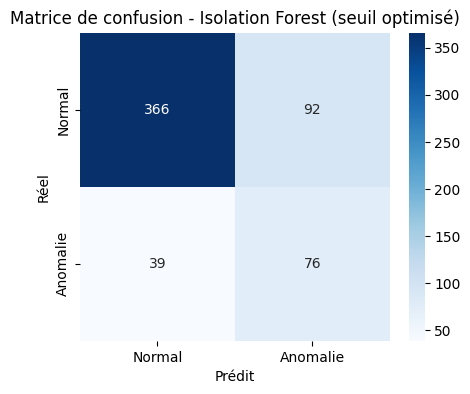

In [52]:
thresholds = np.linspace(min(anomaly_scores), max(anomaly_scores), 200)

best_f1 = 0
best_threshold = 0

for t in thresholds:
    preds = (anomaly_scores >= t).astype(int)
    f1 = f1_score(labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

y_pred = (anomaly_scores >= best_threshold).astype(int)

print("\nðŸ“Š Rapport de classification :")
print(classification_report(labels, y_pred, target_names=["Normal", "Anomalie"]))

roc_auc = roc_auc_score(labels, anomaly_scores)

print(f"ðŸŽ¯ AUC ROC : {roc_auc:.4f}")
avg_precision = average_precision_score(y_true, y_pred)
print(f"Average precision : {avg_precision:.4f}")

# Matrice de confusion
cm = confusion_matrix(labels, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalie"],
            yticklabels=["Normal", "Anomalie"])
plt.xlabel("PrÃ©dit")
plt.ylabel("RÃ©el")
plt.title("Matrice de confusion - Isolation Forest (seuil optimisÃ©)")
plt.show()

In [53]:
oc_svm = OneClassSVM(kernel='poly', gamma='scale') 
oc_svm.fit(df_train)

OneClassSVM(kernel='poly')

In [54]:
svm_pred = oc_svm.decision_function(df_test)
svm_scores = -svm_pred #anomalie >


ðŸ“Š Rapport de classification :
              precision    recall  f1-score   support

      Normal       0.86      0.93      0.89       458
    Anomalie       0.59      0.39      0.47       115

    accuracy                           0.82       573
   macro avg       0.73      0.66      0.68       573
weighted avg       0.81      0.82      0.81       573

ðŸŽ¯ AUC ROC : 0.5059
Average precision : 0.3539


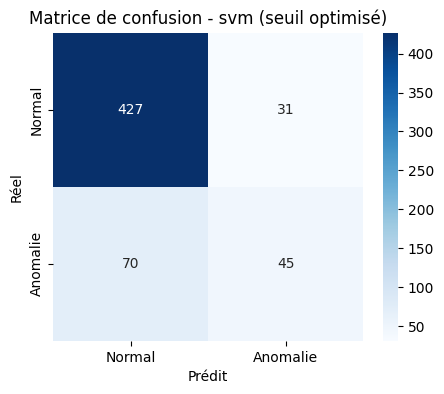

In [55]:
thresholds = np.linspace(min(svm_scores), max(svm_scores), 200)

best_f1 = 0
best_threshold = 0

for t in thresholds:
    preds = (svm_scores >= t).astype(int)
    f1 = f1_score(labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

y_pred = (svm_scores >= best_threshold).astype(int)

print("\nðŸ“Š Rapport de classification :")
print(classification_report(labels, y_pred, target_names=["Normal", "Anomalie"]))

roc_auc = roc_auc_score(labels, svm_scores)
avg_precision = average_precision_score(y_true, y_pred)

print(f"ðŸŽ¯ AUC ROC : {roc_auc:.4f}")
print(f"Average precision : {avg_precision:.4f}")

# Matrice de confusion
cm = confusion_matrix(labels, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Anomalie"],
            yticklabels=["Normal", "Anomalie"])
plt.xlabel("PrÃ©dit")
plt.ylabel("RÃ©el")
plt.title("Matrice de confusion - svm (seuil optimisÃ©)")
plt.show()